## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

In [56]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from torch.utils.data import DataLoader, Dataset, Subset
import torch
from torch import nn
import torchvision

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [95]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

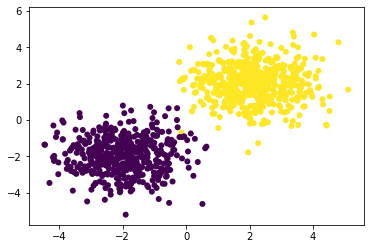

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')
plt.show()

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

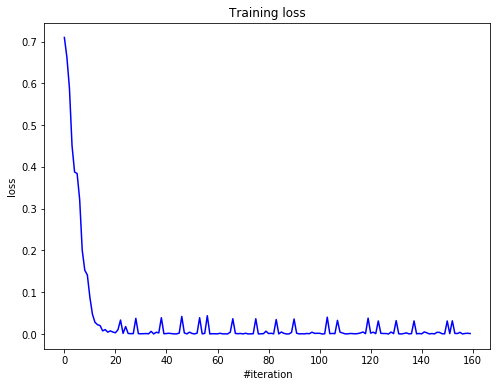

Current loss: 0.001117


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [9]:
BATCH_SIZE = 1024
N_EPOCH = 10
FEATURE_NUM = X_train.shape[1] * X_train.shape[2]
CLASSES_NUM = len(np.unique(y_train))

One-hot encode the labels first.

In [10]:
# Your code goes here. ################################################
def one_hot(labels):
    if labels.ndim != 1:
        return labels
    
    labels_one_hot = np.zeros((len(labels), len(np.unique(labels))))
    labels_one_hot[np.arange(len(labels)), labels] = 1
    return labels_one_hot

y_train, y_val, y_test = one_hot(y_train), one_hot(y_val), one_hot(y_test)

In [11]:
class DatasetMNIST(Dataset):
    def __init__(self, X, y, transform = None):
        self.X = np.array(X)
        self.y = np.array(y)
        self.transform = transform
        assert (X.shape[0] == y.shape[0])
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        obj = self.X[index]
        label = self.y[index]
        
        if self.transform is not None:
            obj = self.transform(obj)
            
        return obj, label

In [29]:
train_dataset = DatasetMNIST(X_train, y_train)
val_dataset = DatasetMNIST(X_val, y_val)
test_dataset = DatasetMNIST(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [66]:
# Your code goes here. ################################################
def SimpleModel(activation_layer, with_batch_norm : bool = False):
    model = Sequential()
    if with_batch_norm:
        model.add(Flatten())
        model.add(Linear(FEATURE_NUM, CLASSES_NUM))
        model.add(BatchNormalization(0.2))
        model[2].moving_mean = np.zeros(CLASSES_NUM)
        model[2].moving_variance = np.ones(CLASSES_NUM)
        model.add(ChannelwiseScaling(CLASSES_NUM))
        model.add(activation_layer)
        model.add(LogSoftMax())
    else:
        model.add(Flatten())
        model.add(Linear(FEATURE_NUM, CLASSES_NUM))
        model.add(activation_layer)
        model.add(LogSoftMax())
    
    return model

def plot_train_process(train_loss, val_loss):
    plt.figure(figsize=(8, 5))

    plt.title('Loss')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='validation')
    plt.legend()
    plt.show()
    pass

def train_model(train_loader, val_loader, model, optimizer, optimizer_config,
                criterion = ClassNLLCriterion(), n_epoch = N_EPOCH):
    
    iteration_train_loss = []
    ep_val_loss = []
    optimizer_state = {}
    
    for i in range(n_epoch):
        model.train()
        for X_batch, y_batch in train_loader:
            model.zeroGradParameters()

            # Forward
            predictions = model.forward(X_batch.numpy())
            loss = criterion.forward(predictions, y_batch.numpy())

            # Backward
            dp = criterion.backward(predictions, y_batch.numpy())
            model.backward(X_batch.numpy(), dp)

            # Update weights
            optimizer(
                model.getParameters(), 
                model.getGradParameters(), 
                optimizer_config,
                optimizer_state
            )      

            iteration_train_loss.append(loss)    
            
        val_loss = []
        model.evaluate()
        for X_batch, y_batch in val_loader:
            predictions = model.forward(X_batch.numpy())
            loss = criterion.forward(predictions, y_batch.numpy())
            val_loss.append(loss)
        
        ep_val_loss.append(np.mean(val_loss))
        
        print("epoch: {}\nmean train loss: {}\nmean val loss: {}\n\n".format(
                                            i,
                                            np.mean(iteration_train_loss),
                                            np.mean(ep_val_loss))
             )
        
    return iteration_train_loss, ep_val_loss

### SGD Momentum optimizer

In [35]:
sgd_momentum_config = {
    "learning_rate" : 1e-2,
    "momentum" : 0.9
}

losses_momentum = {}

In [36]:
ReLUModel = SimpleModel(ReLU())
ReLUBNModel = SimpleModel(ReLU(), with_batch_norm=True)

print("[Training ReLU]")
losses_momentum["ReLU"] = train_model(train_loader, val_loader, ReLUModel, sgd_momentum, sgd_momentum_config)
print("[Training ReLUBN]\n")
losses_momentum["ReLUBN"] = train_model(train_loader, val_loader, ReLUBNModel, sgd_momentum, {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
})

[Training ReLU]
epoch: 0
mean train loss: 1.700174481068345
mean val loss: 1.1175511047921647


epoch: 1
mean train loss: 1.3203694122491476
mean val loss: 0.9024169518432743


epoch: 2
mean train loss: 1.094059347470171
mean val loss: 0.7778984214035164


epoch: 3
mean train loss: 0.9569944865126895
mean val loss: 0.7009948976935846


epoch: 4
mean train loss: 0.865470079849964
mean val loss: 0.6481291164918463


epoch: 5
mean train loss: 0.7994930930043648
mean val loss: 0.6092035053005519


epoch: 6
mean train loss: 0.7493725615257051
mean val loss: 0.5790594184345917


epoch: 7
mean train loss: 0.7097710565769972
mean val loss: 0.5549060850138403


epoch: 8
mean train loss: 0.6775530248896428
mean val loss: 0.5349781027394527


epoch: 9
mean train loss: 0.650712836077496
mean val loss: 0.5181986944042303


[Training ReLUBN]

epoch: 0
mean train loss: 0.9393082136445358
mean val loss: 0.35998747600694275


epoch: 1
mean train loss: 0.6506163886685669
mean val loss: 0.337965393960782

In [37]:
ELUModel = SimpleModel(ELU())
ELUBNModel = SimpleModel(ELU(), with_batch_norm=True)

print("[Training ELU]\n")
losses_momentum["ELU"] = train_model(train_loader, val_loader, ELUModel, sgd_momentum, sgd_momentum_config)
print("[Training ELUBN]\n")
losses_momentum["ELUBN"] = train_model(train_loader, val_loader, ELUBNModel, sgd_momentum, {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
})

[Training ELU]

epoch: 0
mean train loss: 1.430213801308719
mean val loss: 0.7822989422974873


epoch: 1
mean train loss: 1.066167658822563
mean val loss: 0.6733306958712764


epoch: 2
mean train loss: 0.9023385526246586
mean val loss: 0.6122898409781602


epoch: 3
mean train loss: 0.8060496875321361
mean val loss: 0.5715385964261697


epoch: 4
mean train loss: 0.7411926993481633
mean val loss: 0.5418431980881685


epoch: 5
mean train loss: 0.6939134763534968
mean val loss: 0.5189262740140452


epoch: 6
mean train loss: 0.6575426825563226
mean val loss: 0.5005152549260001


epoch: 7
mean train loss: 0.6284889096282441
mean val loss: 0.4853472141861924


epoch: 8
mean train loss: 0.6046146414196115
mean val loss: 0.47253490154143546


epoch: 9
mean train loss: 0.584566750272277
mean val loss: 0.4615608095742127


[Training ELUBN]

epoch: 0
mean train loss: 0.9868362811050674
mean val loss: 0.37533959268240347


epoch: 1
mean train loss: 0.6752589270102537
mean val loss: 0.34478867338666

In [38]:
LeakyReLUModel = SimpleModel(LeakyReLU())
LeakyReLUBNModel = SimpleModel(LeakyReLU(), with_batch_norm=True)

print("[Training LeakyReLU]\n")
losses_momentum["LeakyReLU"] = train_model(train_loader, val_loader, LeakyReLUModel, sgd_momentum, sgd_momentum_config)
print("[Training LeakyReLUBN]\n")
losses_momentum["LeakyRELUBN"] = train_model(train_loader, val_loader, LeakyReLUBNModel, sgd_momentum, {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
})

[Training LeakyReLU]

epoch: 0
mean train loss: 1.7547709105732434
mean val loss: 1.1315277098893906


epoch: 1
mean train loss: 1.2985231803500306
mean val loss: 0.874218174483396


epoch: 2
mean train loss: 1.0687263896481738
mean val loss: 0.7533589487944908


epoch: 3
mean train loss: 0.935266813706391
mean val loss: 0.6804935619944542


epoch: 4
mean train loss: 0.8468824859604152
mean val loss: 0.6307617127155137


epoch: 5
mean train loss: 0.783366513616114
mean val loss: 0.5941010259339985


epoch: 6
mean train loss: 0.7351329793953371
mean val loss: 0.565686106766525


epoch: 7
mean train loss: 0.6970305499696048
mean val loss: 0.5428650010999536


epoch: 8
mean train loss: 0.6659918374827692
mean val loss: 0.5240143258908591


epoch: 9
mean train loss: 0.6401520631094865
mean val loss: 0.5081473629292768


[Training LeakyReLUBN]

epoch: 0
mean train loss: 1.1130203771146758
mean val loss: 0.4225046747164594


epoch: 1
mean train loss: 0.7477471131089614
mean val loss: 0.36838

In [39]:
SoftPlusModel = SimpleModel(SoftPlus())
SoftPlusBNModel = SimpleModel(SoftPlus(), with_batch_norm=True)

print("[Training SoftPlus]\n")
losses_momentum["LeakyReLU"] = train_model(train_loader, val_loader, SoftPlusModel, sgd_momentum, sgd_momentum_config)
print("[Training SoftPlusBN]\n")
losses_momentum["LeakyRELUBN"] = train_model(train_loader, val_loader, SoftPlusBNModel, sgd_momentum, {
    "learning_rate" : 1e-1,
    "momentum" : 0.9
})

[Training SoftPlus]

epoch: 0
mean train loss: 1.7545032004774452
mean val loss: 0.9858914546711037


epoch: 1
mean train loss: 1.2750879495847391
mean val loss: 0.7952102936759948


epoch: 2
mean train loss: 1.0514982566848814
mean val loss: 0.6993375946720749


epoch: 3
mean train loss: 0.921946337249536
mean val loss: 0.6392948647385147


epoch: 4
mean train loss: 0.8360605366780136
mean val loss: 0.5972415839263887


epoch: 5
mean train loss: 0.7742289525881734
mean val loss: 0.5657808527061028


epoch: 6
mean train loss: 0.7272181162310297
mean val loss: 0.5411524368796867


epoch: 7
mean train loss: 0.6900562001717259
mean val loss: 0.5211821520290894


epoch: 8
mean train loss: 0.6597641440821885
mean val loss: 0.5045989873451137


epoch: 9
mean train loss: 0.6345270492559832
mean val loss: 0.49053422475835545


[Training SoftPlusBN]

epoch: 0
mean train loss: 1.0589862020935727
mean val loss: 0.3657114401592591


epoch: 1
mean train loss: 0.7108148995506643
mean val loss: 0.340

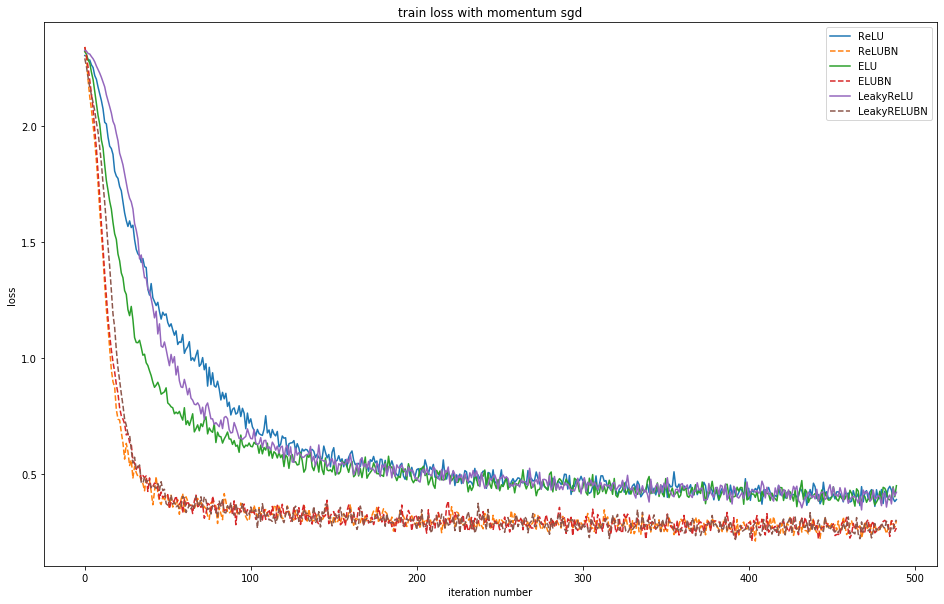

In [40]:
plt.figure(figsize=(16, 10))

for key in losses_momentum:
    if key.find("BN") != -1:
        plt.plot(losses_momentum[key][0], label=key, linestyle = '--')
    else:
        plt.plot(losses_momentum[key][0], label=key)

plt.title("train loss with momentum sgd")
plt.xlabel("iteration number")
plt.ylabel("loss")
plt.legend()
plt.show()

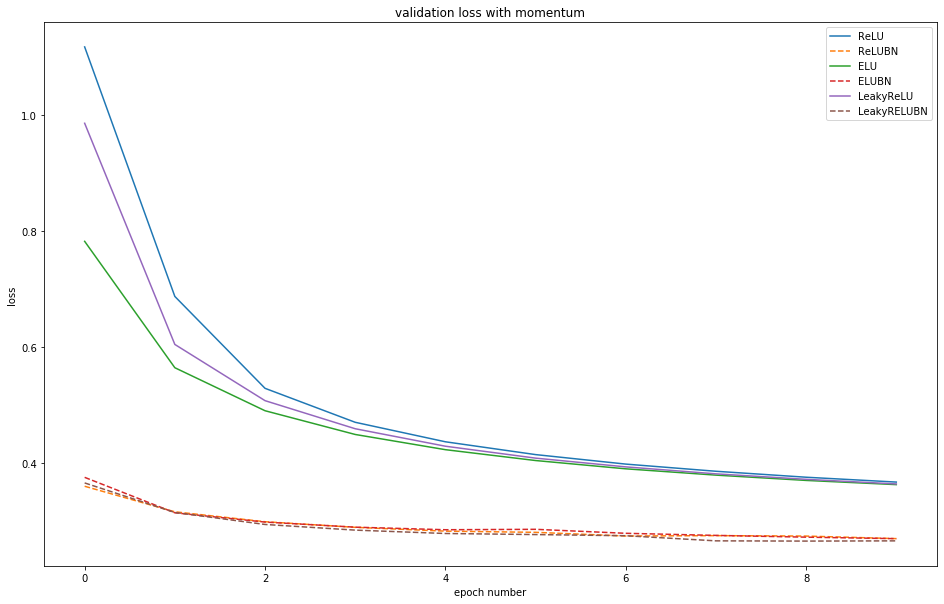

In [41]:
plt.figure(figsize=(16, 10))

for key in losses_momentum:
    if key.find("BN") != -1:
        plt.plot(losses_momentum[key][1], label=key, linestyle = '--')
    else:
        plt.plot(losses_momentum[key][1], label=key)

plt.title("validation loss with momentum")
plt.xlabel("epoch number")
plt.ylabel("loss")
plt.legend()
plt.show()

### Adam optimizer

In [42]:
adam_config_default = {
    "learning_rate" : 1e-3,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
}

losses_adam = {}

In [43]:
ReLUModel = SimpleModel(ReLU())
ReLUBNModel = SimpleModel(ReLU(), with_batch_norm=True)

print("[Training ReLU]\n")
losses_adam["ReLU"] = train_model(train_loader, val_loader, ReLUModel, adam_optimizer, adam_config_default)
print("[Training ReLUBN]\n")
losses_adam["ReLUBN"] = train_model(train_loader, val_loader, ReLUBNModel, adam_optimizer, {
    "learning_rate" : 5e-2,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
})

[Training ReLU]

epoch: 0
mean train loss: 1.7604963626005712
mean val loss: 1.3088354481296904


epoch: 1
mean train loss: 1.4471105393457495
mean val loss: 1.0980832455656717


epoch: 2
mean train loss: 1.2481902064343922
mean val loss: 0.9808945187929217


epoch: 3
mean train loss: 1.1239997276215596
mean val loss: 0.9054467931518766


epoch: 4
mean train loss: 1.038328112207175
mean val loss: 0.8519626905084028


epoch: 5
mean train loss: 0.975079748746191
mean val loss: 0.8116477285634155


epoch: 6
mean train loss: 0.9260852891308573
mean val loss: 0.7798311807063903


epoch: 7
mean train loss: 0.8867944608196002
mean val loss: 0.7539851051343911


epoch: 8
mean train loss: 0.8544678654537782
mean val loss: 0.7325601721714127


epoch: 9
mean train loss: 0.827269728249106
mean val loss: 0.7143667449332023


[Training ReLUBN]

epoch: 0
mean train loss: 0.9518004859596478
mean val loss: 0.40681816839713464


epoch: 1
mean train loss: 0.668552353242753
mean val loss: 0.36386362506034

In [44]:
ELUModel = SimpleModel(ELU())
ELUBNModel = SimpleModel(ELU(), with_batch_norm=True)

print("[Training ELU]\n")
losses_adam["ELU"] = train_model(train_loader, val_loader, ELUModel, adam_optimizer, adam_config_default)
print("[Training ELUBN]\n")
losses_adam["ELUBN"] = train_model(train_loader, val_loader, ELUBNModel, adam_optimizer, {
    "learning_rate" : 5e-2,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
})

[Training ELU]

epoch: 0
mean train loss: 1.521733226041444
mean val loss: 0.9618108597305832


epoch: 1
mean train loss: 1.1715345400373132
mean val loss: 0.7997919437688639


epoch: 2
mean train loss: 0.9877189084253193
mean val loss: 0.7050694166311406


epoch: 3
mean train loss: 0.8725878401159348
mean val loss: 0.6416171200347516


epoch: 4
mean train loss: 0.7925921979053159
mean val loss: 0.5956948455824542


epoch: 5
mean train loss: 0.7331669454100378
mean val loss: 0.5605120022530076


epoch: 6
mean train loss: 0.6869789043873845
mean val loss: 0.532485823182484


epoch: 7
mean train loss: 0.6498281652788167
mean val loss: 0.509580152666731


epoch: 8
mean train loss: 0.6191984381445563
mean val loss: 0.4904187172361119


epoch: 9
mean train loss: 0.5934310865905945
mean val loss: 0.4741499245328705


[Training ELUBN]

epoch: 0
mean train loss: 0.929318696888087
mean val loss: 0.41347539149960416


epoch: 1
mean train loss: 0.660504994088071
mean val loss: 0.3693677181840559


In [45]:
LeakyReLUModel = SimpleModel(LeakyReLU())
LeakyReLUBNModel = SimpleModel(LeakyReLU(), with_batch_norm=True)

print("[Training LeakyReLU]\n")
losses_adam["LeakyReLU"] = train_model(train_loader, val_loader, LeakyReLUModel, adam_optimizer, adam_config_default)
print("[Training LeakyReLUBN]\n")
losses_adam["LeakyRELUBN"] = train_model(train_loader, val_loader, LeakyReLUBNModel, adam_optimizer, {
    "learning_rate" : 5e-2,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
})

[Training LeakyReLU]

epoch: 0
mean train loss: 1.561227563138713
mean val loss: 0.9834700097094589


epoch: 1
mean train loss: 1.195255667772197
mean val loss: 0.8120972581445562


epoch: 2
mean train loss: 1.0033858047916333
mean val loss: 0.7128396354650525


epoch: 3
mean train loss: 0.8838441822942527
mean val loss: 0.6469293051267574


epoch: 4
mean train loss: 0.8011207608629032
mean val loss: 0.599266612594209


epoch: 5
mean train loss: 0.7398853248290221
mean val loss: 0.5629459514849506


epoch: 6
mean train loss: 0.6923917849072909
mean val loss: 0.5342467436844875


epoch: 7
mean train loss: 0.6542817809732712
mean val loss: 0.5108039151000514


epoch: 8
mean train loss: 0.6229169254001495
mean val loss: 0.4912329440224409


epoch: 9
mean train loss: 0.5965644327751719
mean val loss: 0.4745796086542434


[Training LeakyReLUBN]

epoch: 0
mean train loss: 0.9817622146603048
mean val loss: 0.41504135905735823


epoch: 1
mean train loss: 0.6860797505136801
mean val loss: 0.371

In [46]:
SoftPlusModel = SimpleModel(SoftPlus())
SoftPlusBNModel = SimpleModel(SoftPlus(), with_batch_norm=True)

print("[Training SoftPlus]\n")
losses_adam["LeakyReLU"] = train_model(train_loader, val_loader, SoftPlusModel, adam_optimizer, adam_config_default)
print("[Training SoftPlusBN]\n")
losses_adam["LeakyRELUBN"] = train_model(train_loader, val_loader, SoftPlusBNModel, adam_optimizer, {
    "learning_rate" : 5e-2,
    "beta1" : 0.9,
    "beta2" : 0.999,
    "epsilon" : 1e-8
})

[Training SoftPlus]

epoch: 0
mean train loss: 1.6415033205886618
mean val loss: 1.0105425334537057


epoch: 1
mean train loss: 1.2342176276452916
mean val loss: 0.8152347309976434


epoch: 2
mean train loss: 1.02307289151199
mean val loss: 0.7080567353317053


epoch: 3
mean train loss: 0.8941171909167003
mean val loss: 0.6388814332801968


epoch: 4
mean train loss: 0.8061575106235664
mean val loss: 0.5897436386847228


epoch: 5
mean train loss: 0.7417299846933181
mean val loss: 0.5528831094744916


epoch: 6
mean train loss: 0.6921553702719341
mean val loss: 0.523854515041912


epoch: 7
mean train loss: 0.6526419597273423
mean val loss: 0.5003534122635942


epoch: 8
mean train loss: 0.6203146961169375
mean val loss: 0.4808979651543933


epoch: 9
mean train loss: 0.5932663763487102
mean val loss: 0.4644967782873571


[Training SoftPlusBN]

epoch: 0
mean train loss: 1.0444327844405565
mean val loss: 0.40736833149997426


epoch: 1
mean train loss: 0.7130115926921068
mean val loss: 0.36240

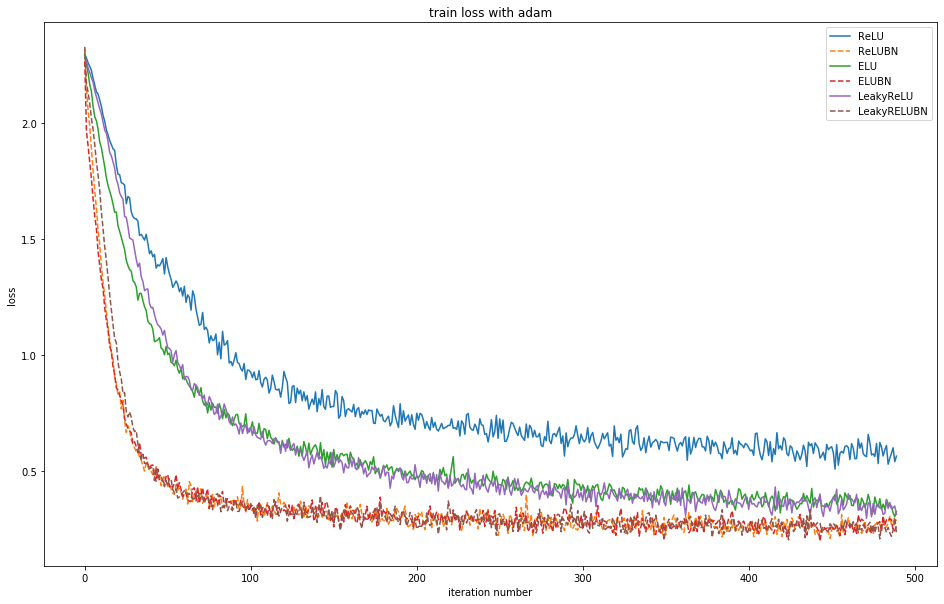

In [47]:
plt.figure(figsize=(16, 10))

for key in losses_adam:
    if key.find("BN") != -1:
        plt.plot(losses_adam[key][0], label=key, linestyle = '--')
    else:
        plt.plot(losses_adam[key][0], label=key)

plt.title("train loss with adam")
plt.xlabel("iteration number")
plt.ylabel("loss")
plt.legend()
plt.show()

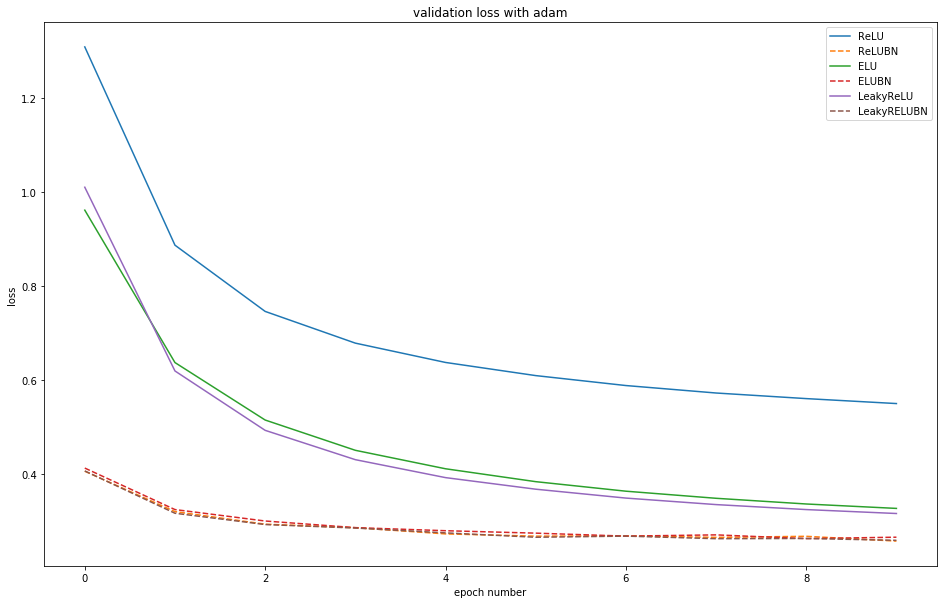

In [48]:
plt.figure(figsize=(16, 10))

for key in losses_adam:
    if key.find("BN") != -1:
        plt.plot(losses_adam[key][1], label=key, linestyle = '--')
    else:
        plt.plot(losses_adam[key][1], label=key)

plt.title("validation loss with adam")
plt.xlabel("epoch number")
plt.ylabel("loss")
plt.legend()
plt.show()

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

- Лучше всего в обоих случая показала себя ELU, хуже остальных - ReLU. Однако ELU содержит exp, которую затратно вычислять, поэтому я склоняюсь к выбору LeakyReLU, которая лишена проблемы ReLU с нулевым градиентом, а также вычислительно не затратна

- Добавление батчнорма позволяет обучаться лучше увеличивая learning_rate, тк нормируя выход с линейного слоя мы получаем гарантию того, что данные в следующий слой скорее всего придут с mean = 0, variance = 1 и мы можем изменять веса на бо'льшую величину, по сравнению с моделью без батчнорма. Также наличие shift + scale позволяет тюнить эти параметры, адаптируясь под следующий слой.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [106]:
# dataloader
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.RandomAffine((0,0)),
    torchvision.transforms.ToTensor(),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_dataset = DatasetMNIST(X_train, y_train, train_transforms)
val_dataset = DatasetMNIST(X_val, y_val, test_transforms)
test_dataset = DatasetMNIST(X_test, y_test, test_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [109]:
# Your code goes here. ################################################
model = Sequential()
model.add(Flatten())
model.add(Linear(FEATURE_NUM, CLASSES_NUM))
model.add(BatchNormalization(0.2))
model[-1].moving_mean = np.zeros(CLASSES_NUM)
model[-1].moving_variance = np.ones(CLASSES_NUM)
model.add(LeakyReLU())
model.add(Linear(CLASSES_NUM, CLASSES_NUM))
model.add(ELU())
model.add(Dropout())
model.add(LogSoftMax())

print(model)

Flatten
Linear 784 -> 10
BatchNormalization
LeakyReLU
Linear 10 -> 10
ELU
Dropout
LogSoftMax



In [110]:
sgd_momentum_config = {
    "learning_rate" : 1e-2,
    "momentum" : 0.9
}

train_losses, val_losses = train_model(train_loader, val_loader, model, sgd_momentum, sgd_momentum_config)

epoch: 0
mean train loss: 1.4552521551801145
mean val loss: 0.8145270669765752


epoch: 1
mean train loss: 1.3550282724881302
mean val loss: 0.7549169790777335


epoch: 2
mean train loss: 1.3084287182978014
mean val loss: 0.7009763161228566


epoch: 3
mean train loss: 1.2762559776042248
mean val loss: 0.6712494351677244


epoch: 4
mean train loss: 1.2545821242284112
mean val loss: 0.650866356329157


epoch: 5
mean train loss: 1.238853438909797
mean val loss: 0.6297402345526083


epoch: 6
mean train loss: 1.2266735001694353
mean val loss: 0.6134372712398265


epoch: 7
mean train loss: 1.2176170997730125
mean val loss: 0.5986425432834108


epoch: 8
mean train loss: 1.2089790118335377
mean val loss: 0.586906474048734


epoch: 9
mean train loss: 1.2026072053265475
mean val loss: 0.5770583717607598




Print here your accuracy on test set. It should be around 90%.

In [132]:
# Your answer goes here. ################################################
model.evaluate()
y_pred = np.array([])
y_label = np.array([])


for X_batch, y_batch in train_loader:
    out = model.forward(X_batch.numpy())
        
    y_pred = np.concatenate((y_pred, out.argmax(axis=1)))
    y_label = np.concatenate((y_label, y_batch.numpy().argmax(axis=1)))
    
print("accuracy", np.mean(y_label == y_pred))

accuracy 0.91664


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [30]:
# Your beautiful code here.